In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
from pydub import AudioSegment
from glob import glob
import sox
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pickle

import IPython.display as ipd

In [3]:
# color palate for plotting
colors = ['#6c503e', '#446652','#8C93A8', '#ED7D3A', '#B5C2B7']

# Inspect Data
## Look at kaggle DataFrame

In [4]:
df = pd.read_csv('input/birdclef-2021/train_metadata.csv')
df.head()

primary_label secondary_labels                                  type  \
0        acafly       ['amegfi']  ['begging call', 'call', 'juvenile']   
1        acafly               []                              ['call']   
2        acafly               []                              ['call']   
3        acafly      ['whwbec1']                              ['call']   
4        acafly      ['whwbec1']                              ['call']   

   latitude  longitude      scientific_name         common_name  \
0   35.3860   -84.1250  Empidonax virescens  Acadian Flycatcher   
1    9.1334   -79.6501  Empidonax virescens  Acadian Flycatcher   
2    5.7813   -75.7452  Empidonax virescens  Acadian Flycatcher   
3    4.6717   -75.6283  Empidonax virescens  Acadian Flycatcher   
4    4.6717   -75.6283  Empidonax virescens  Acadian Flycatcher   

                       author        date      filename  \
0                 Mike Nelson  2012-08-12  XC109605.ogg   
1           Allen T. Chartier  2000-12-26   XC11209.ogg   
2     Sergio Chaparro-Herrera  2012-01-10  XC127032.ogg   
3  Oscar Humberto Marin-Gomez  2009-06-19  XC129974.ogg   
4  Oscar Humberto Marin-Gomez  2009-06-19  XC129981.ogg   

                                             license  rating   time  \
0  Creative Commons Attribution-NonCommercial-Sha...     2.5  09:30   
1  Creative Commons Attribution-NonCommercial-Sha...     3.0      ?   
2  Creative Commons Attribution-NonCommercial-Sha...     3.0  15:20   
3  Creative Commons Attribution-NonCommercial-Sha...     3.5  07:50   
4  Creative Commons Attribution-NonCommercial-Sha...     3.5  07:50   

                                 url  
0  https://www.xeno-canto.org/109605  
1   https://www.xeno-canto.org/11209  
2  https://www.xeno-canto.org/127032  
3  https://www.xeno-canto.org/129974  
4  https://www.xeno-canto.org/129981

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


All of the columns are object except xc_id, duration, and rating.  This probably means that many of the columns have missing values.  I won't tackle them unless necessary.

In [6]:
df.describe()

latitude     longitude        rating
count  62874.000000  62874.000000  62874.000000
mean      24.472805    -79.960828      3.755360
std       22.108481     38.370726      1.220135
min      -53.162000   -165.781200      0.000000
25%        6.246000   -108.976100      3.500000
50%       31.741400    -81.553400      4.000000
75%       41.198700    -73.133333      4.500000
max       78.928100    179.360700      5.000000

## Known column values

`rating` - Rate the quality of this recording 0 - 5 (0 is worst) originally (A is best, E worst)

`playback_used` - was playback used to lure the bird? (yes/no)

`ebird_code`: a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow

`channels` - mono or stereo recording

`date` - the date that the recording was 

`pitch` - Describes the pitch shape of the observed sound

`recodist`: the user who provided the recording.

`location`: where the recording was taken. Some bird species may have local call 'dialects', so you may want to seek geographic diversity in your training data.

`date`: while some bird calls can be made year round, such as an alarm call, some are restricted to a specific season. You may want to seek temporal diversity in your training data.

`filename`: the name of the associated audio file.

**API values**
    
    id: the catalogue number of the recording on xeno-canto
    gen: the generic name of the species
    sp: the specific name (epithet) of the species
    ssp: the subspecies name (subspecific epithet)
    en: the English name of the species
    rec: the name of the recordist
    cnt: the country where the recording was made
    loc: the name of the locality
    lat: the latitude of the recording in decimal coordinates
    lng: the longitude of the recording in decimal coordinates
    type: the sound type of the recording (e.g. 'call', 'song', etc). This is generally a comma-separated list of sound types.
    url: the URL specifying the details of this recording
    file: the URL to the audio file
    file-name: the original file name of the audio file
    sono: an object with the urls to the four versions of sonograms
    lic: the URL describing the license of this recording
    q: the current quality rating for the recording
    length: the length of the recording in minutes
    time: the time of day that the recording was made
    date: the date that the recording was made
    uploaded: the date that the recording was uploaded to xeno-canto
    also: an array with the identified background species in the recording
    rmk: additional remarks by the recordist
    bird-seen: was the recorded bird visually identified? (yes/no)
    playback-used: was playback used to lure the bird? (yes/no)


In [10]:
# num unique classes
df['primary_label'].nunique()


397

We are looking at a multi class problem with 397 possible values.  Phew.

## Number of recordings for each species

In [11]:
df['primary_label'].value_counts()

barswa     500
rewbla     500
houspa     500
norcar     500
cubthr     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
stvhum2      8
crfpar       8
Name: primary_label, Length: 397, dtype: int64

In [13]:
# percentage of species with 100 samples
sum(df['primary_label'].value_counts() == 500) / df['primary_label'].nunique()

0.030226700251889168

In [14]:
# percentage of species with fewer than 50 samples
sum(df['primary_label'].value_counts() <= 50) / df['primary_label'].nunique()

0.07304785894206549

Half of the species have 100 samples but 17.4% of the species have fewer than 50 samples.  This could cause problems for our testing.  **We will need to augment this data or acquire more.**

# Visualize the audio

## wavform

input/birdclef-2021/train_short_audio/linwoo1/XC258056.ogg


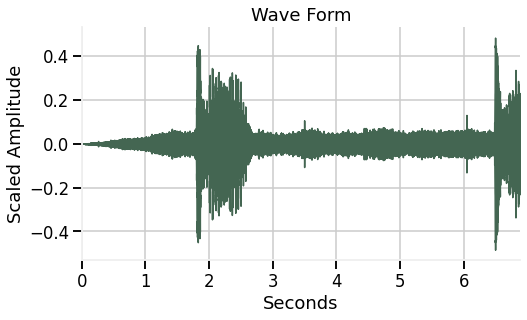

Imported Sample-rate is: 32000


In [16]:
# show the wavefrom of a random recording
train_audio_path = 'input/birdclef-2021/train_short_audio/'

row = df.sample(1).iloc[0] # random row as series
#row = df[df['filename'] == 'XC168055.mp3'].iloc[0]

path = os.path.join(train_audio_path, row['primary_label'], row['filename'])
print(path)
data, sr = librosa.load(path, sr=None, mono=True)


with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1):

    fig = plt.figure(figsize=(7,4))
    librosa.display.waveplot(data[:220500], sr= sr, color=colors[1])

    ax = plt.gca()
    plt.title('Wave Form')
    plt.xlabel('Seconds')

    # fix for y label has been assigned to a string by wavplot
    ax.set_ylabel('Scaled Amplitude')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Make Transparent
    fig.set_facecolor('None')
    ax.set_facecolor('None')

    plt.show()



# stats
print('Imported Sample-rate is:', sr)

# display playback
ipd.Audio(path)

In [17]:
data.shape

(1003555,)

Notice the imported files are scaled from -1 to 1, sample rate converted to 22500, and converts to mono.

## Spectrogram

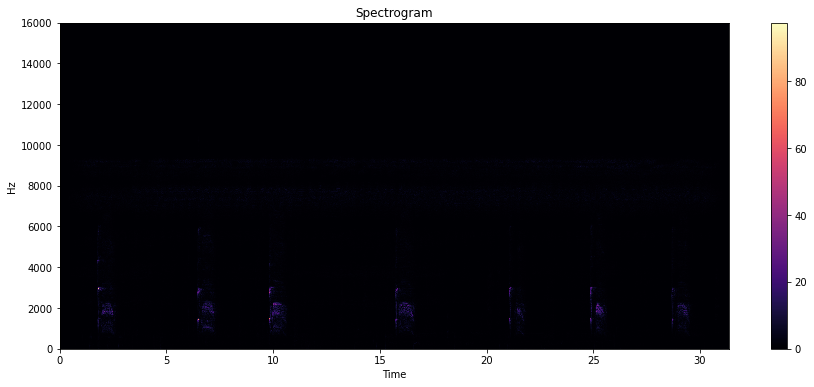

In [18]:
# load the file
hop_length = 512
n_fft = 2048
stft = librosa.stft(data, n_fft=n_fft,  hop_length=hop_length)

# get magnitude
spectrogram = np.abs(stft)

# plot
plt.figure(figsize=(15,6))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();
plt.title('Spectrogram');

## Log Spectrogram (decibels)
The log spectrogram converts the magnitude to decibels.  Decibels are on log scale to mimic human hearing.

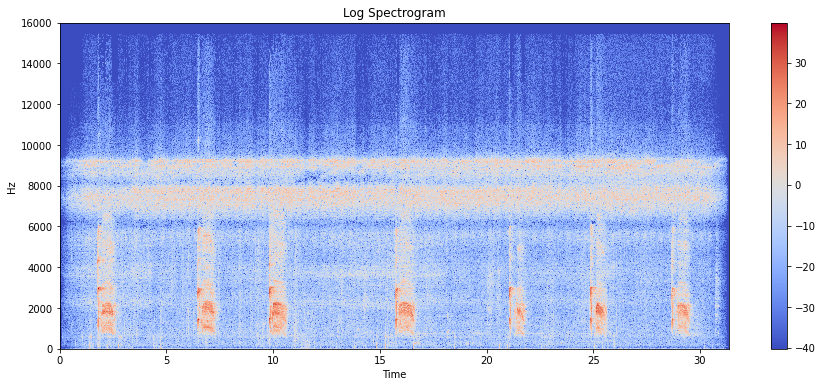

In [19]:
# convert spectrogram to log_spectrogram
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# plot
plt.figure(figsize=(15,6))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();

plt.title('Log Spectrogram');


## Mel Spectrogram
The mel spectrogram further converts the frequency to mel scale.  Mels are on a log scale to mimic human hearing.

/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Text(0.5, 1.0, 'Mel Spectrogram')

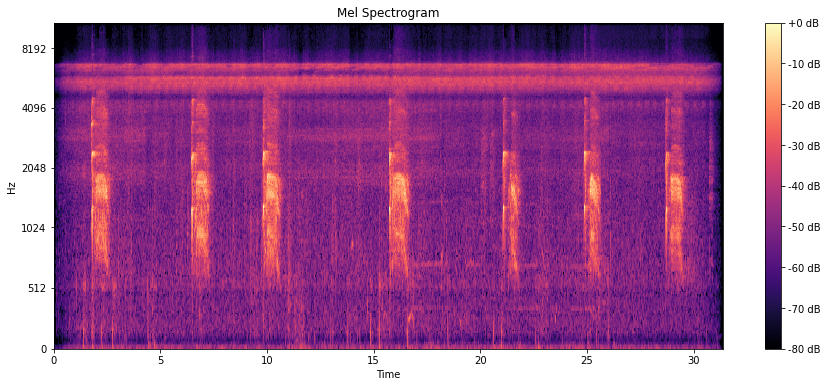

In [20]:
# Create mel spectrogram
n_mels = 256
S = librosa.feature.melspectrogram(data, 
                                   sr=sr, 
                                   n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)

# convert magnitude to db
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
fig = plt.figure(figsize=(15,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram')

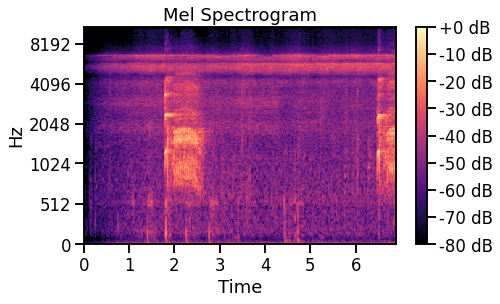

In [21]:
# mel spectrogram plot for presentation

# plot mel spectrogram
n_mels = 256
S = librosa.feature.melspectrogram(data[:220500], 
                                   sr=sr, 
                                   n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
# convert to db
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
with sns.plotting_context("talk", font_scale=1):

    fig = plt.figure(figsize=(7,4))

    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram')

    # Make Transparent for presentation
    fig.set_facecolor('None')
    ax.set_facecolor('None')

# Files

In [24]:
# get list of all the mp3 files
audio_files = glob('input/birdclef-2021/train_short_audio/*/*.ogg', recursive=True)
audio_files[:5]

['input/birdclef-2021/train_short_audio/acafly/XC109605.ogg',
 'input/birdclef-2021/train_short_audio/acafly/XC11209.ogg',
 'input/birdclef-2021/train_short_audio/acafly/XC127032.ogg',
 'input/birdclef-2021/train_short_audio/acafly/XC129974.ogg',
 'input/birdclef-2021/train_short_audio/acafly/XC129981.ogg']

## Get statistics from recordings

In [25]:
# check if we already have a stored version of this data
path = 'dataframes'
fname = os.path.join(path,'audio_files_df.pkl')


if os.path.exists(fname):
    # Load the dataframe if it is saved
    with open(fname, 'rb') as fp:
        audio_files_df = pickle.load(fp)
    print('Loaded dataframe from disk')

else:
    # data holder
    stats = {
        'duration': [],
        'sample_rate': [],
        'bitrate': [],
        'bird_id': [],
        'file_name': []
    }

    # loop through files to extract metrics
    for af in tqdm(audio_files):    
        stats['duration'].append(sox.file_info.duration(af))
        stats['sample_rate'].append(sox.file_info.sample_rate(af))    
        stats['bitrate'].append(sox.file_info.bitrate(af))

        path_split = af.split('/')
        stats['bird_id'].append(path_split[-2])
        stats['file_name'].append(path_split[-1])

    # create the dataframe from stats
    audio_files_df = pd.DataFrame(stats)
    
    # save the dataframe
    os.makedirs(path, exist_ok=True)
    with open(fname, 'wb') as fp:
        pickle.dump(audio_files_df, fp)

100%|██████████| 62874/62874 [1:06:56<00:00, 15.65it/s]


In [26]:
# look at df
audio_files_df.head()

duration  sample_rate   bitrate bird_id     file_name
0  63.674563      32000.0   93500.0  acafly  XC109605.ogg
1  16.654156      32000.0  103000.0  acafly   XC11209.ogg
2  47.139063      32000.0   91500.0  acafly  XC127032.ogg
3  14.068031      32000.0   95100.0  acafly  XC129974.ogg
4  40.660688      32000.0   94800.0  acafly  XC129981.ogg

In [27]:
# descriptive statistics
audio_files_df.describe()

duration  sample_rate        bitrate
count  62874.000000      62874.0   62874.000000
mean      56.255305      32000.0   96132.087461
std       74.042363          0.0    7701.139449
min        5.958125      32000.0      87.000000
25%       18.378250      32000.0   92000.000000
50%       34.260688      32000.0   95200.000000
75%       66.205000      32000.0   99300.000000
max     2745.352937      32000.0  221000.000000

## Duration

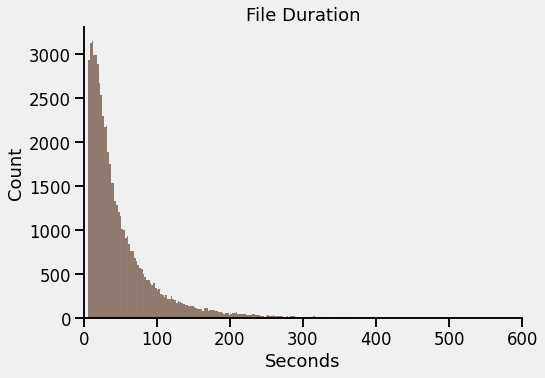

In [28]:
# plot file duration
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", 
                                                                font_scale=1):
    
    # create fig and plot
    fig = plt.figure(figsize=(7,5))
    ax = sns.histplot(audio_files_df['duration'], color=colors[0])
    
    # xaxis range (crop off outliers)
    plt.xlim([0, 600])
    
    # labels
    plt.title('File Duration')
    plt.xlabel('Seconds')
    
    # formatting    
    plt.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

### Duration Outliers
There are some definte outliers. We need to know if they have an example of the bird song at the beginning of the track and if they don't we should drop them.

In [22]:
audio_files_df[audio_files_df['duration'] > 20]

duration  sample_rate   bitrate bird_id     file_name
0       86.273000      48000.0  320000.0  olsfly  XC386256.mp3
2       55.129002      44100.0  129000.0  olsfly  XC239498.mp3
4       60.393991      44100.0  129000.0  olsfly  XC156193.mp3
5       57.338005      44100.0  113000.0  olsfly  XC430786.mp3
6      104.937007      44100.0  128000.0  olsfly  XC249977.mp3
...           ...          ...       ...     ...           ...
21346   70.355011      44100.0  128000.0  grnher  XC144306.mp3
21348   25.623991      44100.0  193000.0  grnher  XC319278.mp3
21352   25.971000      48000.0  130000.0  grnher  XC173633.mp3
21359   21.390000      48000.0  130000.0  grnher  XC253773.mp3
21373   28.759002      44100.0  193000.0  grnher  XC315553.mp3

[14433 rows x 5 columns]

In [23]:
# what are the longest files?
audio_files_df = audio_files_df.sort_values('duration', ascending=False)
audio_files_df.head()

duration  sample_rate   bitrate bird_id     file_name
1064   2283.936000      48000.0   80300.0  comrav  XC246425.mp3
20355  2240.612993      44100.0  320000.0  snobun  XC487556.mp3
20350  2138.572993      44100.0  320000.0  snobun  XC487557.mp3
20904  1285.213000      48000.0  320000.0  stejay  XC503349.mp3
7680   1093.650000      48000.0  320000.0  prawar  XC479026.mp3

Check the longest files to see if there is a bird song in the first 10 seconds.

These codeblocks load the audio files into the jupyter notebook memory and make the file too large for github.  Uncomment to hear the files.

In [24]:
# audio_path = os.path.join('data/train_audio/',
#                           audio_files_df.iloc[0].bird_id,
#                           audio_files_df.iloc[0].file_name)
# ipd.Audio(filename=audio_path)

In [25]:
# audio_path = os.path.join('data/train_audio/',
#                           audio_files_df.iloc[1].bird_id,
#                           audio_files_df.iloc[1].file_name)
# ipd.Audio(filename=audio_path)

In [26]:
# audio_path = os.path.join('data/train_audio/',
#                           audio_files_df.iloc[2].bird_id,
#                           audio_files_df.iloc[2].file_name)
# ipd.Audio(filename=audio_path)

It does sound like we get the call in the first 10 seconds!

## Sample Rate

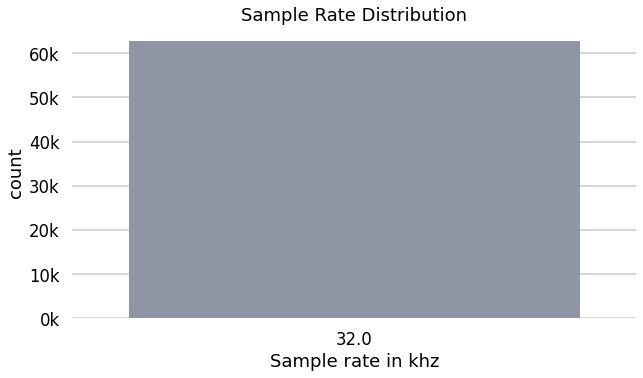

In [29]:
# plot sample rate distribution
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1):
    
    # create figure and plot
    fig = plt.figure(figsize=(9,5))
    ax = sns.countplot(x = audio_files_df['sample_rate']/1000,
                       color=colors[2])
    
    # formatting
    plt.title('Sample Rate Distribution');
    plt.xlabel('Sample rate in khz')
    plt.box(on=False)
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.yaxis.set_major_formatter(lambda x, pos: str(int(x/1000)) + 'k')

    # make transparent for presentation
    fig.set_facecolor('None')
    ax.set_facecolor('None')

Most of the files are at CD quality 44.1 khz.

## Bitrate

Text(0.5, 1.0, 'Bitrate Distribution')

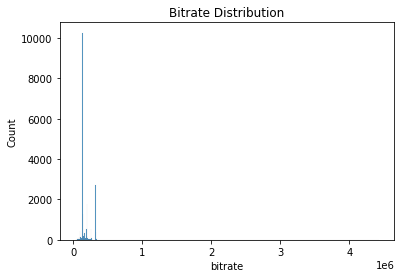

In [28]:
# plot bitrate distribution
sns.histplot(audio_files_df['bitrate'])
plt.title('Bitrate Distribution')

There are some outliers with very high bitrates. Zoom in on < 500000

Text(0.5, 1.0, 'Bitrate (< 500khz) Distribution')

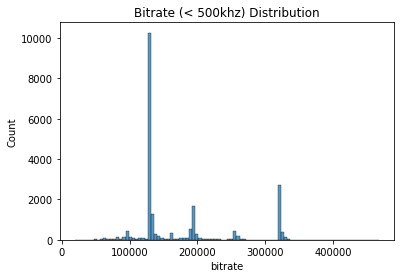

In [29]:
# plot bitrates below 500khz
sns.histplot(audio_files_df[audio_files_df['bitrate'] < 500000]['bitrate'])
plt.title('Bitrate (< 500khz) Distribution')

It looks like most of the files are above 128k or higher bitrate mp3 files.  Some the values that do not align with common values may be variable bitrate files.

# Recording Location
Plotly does better with mapping many points than matplotlib.  Map the location of all of the recordings.

In [30]:
# plot
fig = px.scatter_geo(df,
                    lat=df.latitude,
                    lon=df.longitude,
                    title='Bird Recording Locations',
                    color_discrete_sequence=[colors[1]]
)

# from hex to rgb color with transparency
h = colors[2].lstrip('#')
rgb_landcolor = list(int(h[i:i+2], 16) for i in (0, 2, 4))
rgb_landcolor.append(0.3) # opacity
rgb_landcolor = 'rgba'+str(tuple(rgb_landcolor))

# set colors
fig.update_layout(
    go.Layout(
        geo = dict(
            landcolor = rgb_landcolor
        ),
        # for presentation
        # paper_bgcolor='rgba(0,0,0,0)',
        # plot_bgcolor='rgba(0,0,0,0)'
    )
)
fig.show()